In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import matplotlib
from PIL import Image
import pyximport
pyximport.install(language_level=3)
from sims.prs import filter_PRS_histograms, get_sup_ent_lists
from sims.visualization import filter_graphs_with_local_data, RelationshipVisualizer
from config import COCO_PRS_json_path, COCO_SGS_dir

with open(COCO_PRS_json_path, 'r') as f:
    prs = json.load(f)
maxentr = entropy([1/3,1/3,1/3])
minsup = 64
filtered_prs = filter_PRS_histograms(prs, minsup, maxentr)

## Co-occurrence
Some classes co-occur very often in the images (e.g. person, book, car).
During mining process it may be useful to consider "people", "books", "cars".

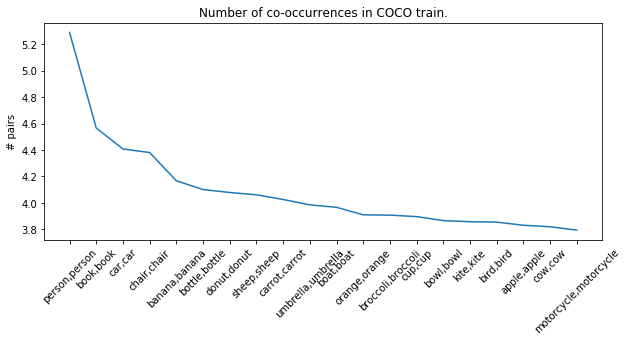

In [4]:
cooccur = sorted([(p,h['sup']) for p, h in prs.items() if p.split(',')[0]==p.split(',')[1]],key=lambda pair: -pair[1])
p = [el[0] for el in cooccur]
s = [el[1] for el in cooccur]
plt.figure(figsize=[10,4])
plt.plot(p[:20],np.log10(s[:20]))
plt.xticks(rotation=45)
plt.ylabel('# pairs')
plt.title('Number of co-occurrences in COCO train.')
plt.show()

The co-occurrence of many objects of the same class may generate different graphs which has poor degree of abstraction.
Let's show two examples of frequent graphs with a lot of "people" inside.

In [8]:
with open(os.path.join(COCO_SGS_dir, 'sgs_eprune_gspan_01.json')) as f:
    freq_graphs = json.load(f)

In [9]:
def print_graph(g):
    print("Freq graph:")
    string = []
    node_labels = {n['id']:n['label'] for n in g['nodes']}
    for l in g['links']:
        string.append(f"{node_labels[l['s']]}, {l['pos']}, {node_labels[l['r']]}")
    for str_i in string:
        print(str_i)

def has_people(g, freq=4):
    if 'nodes' not in g:
        return False
    node_labels = [n['label'] for n in g['nodes']]
    u_l,c_l = np.unique(node_labels,return_counts=True)
    for u,c in zip(u_l,c_l):
        if u=='person' and c>freq:
            return True
    return False

freq_graph_people = []
for g in freq_graphs:
    if has_people(g['g']):
        freq_graph_people.append(g)
i = 8
print_graph(freq_graph_people[0]['g'])
print_graph(freq_graph_people[1]['g'])

Freq graph:
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, side-down, sky-other-merged
Freq graph:
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged
person, below, sky-other-merged


Information in the graphs above are redundant.
Two better representations would be:

```
Freq graph
People below sky-other-merged
Person side-down sky-other-merged

Freq graph:
People below sky-other-merged
```

## GSpan, Pruned equivalent nodes
- Analysis of results after pruning equivalent nodes.

In [17]:
from sims.graph_clustering import subgraph_isomorphism
from sims.graph_mining import get_exp_name

with open(os.path.join(COCO_SGS_dir,"preparedGraphs_eprune_nprune.json") as f:
    train_graphs = json.load(f)

In [24]:
from sims.graph_utils import json_to_nx
from sims.graph_utils import print_graph_picture

def match_freq_graph(freq_graph, graphs, max_results):
    """
    Match frequent graph against a list of graphs
    :param freq_graph: frequent json graph to be matched
    :param graphs: list of json graphs to look for the frequent graph
    :parma max_results: maximum number of matched graphs retrieved in the result
    """
    results = []
    fglabels = set([n['label'] for n in freq_graph['nodes']])
    for g in graphs:
        
        glabels = set([n['label'] for n in g['nodes']])
        res = []
        if len(fglabels-glabels)==0:
            res = subgraph_isomorphism(freq_graph, g)
        if len(res)>0:
            results.append((g, res[0]))
        if len(results)>=max_results:
            break
    return results

def filter_matched_graph(graph, freq_graph, node_matching):
    """
    Given a graph-subgraph matching, filter graph nodes with only the matched nodes.
    :param graph: graph that contains the frequent graph
    :param freq_graph: frequent graph
    :param node_matching: map between node ids of graph and the matched freq_graph (use match_freq_graph())
    :return graph with filtered nodes and edges (only those that match)
    """
    node_matching = {v:k for k,v in node_matching.items()}
    links = []
    nodes = []
    for edge in freq_graph['links']:
        converted_e = edge.copy()
        converted_e['s']=node_matching[converted_e['s']]
        converted_e['r']=node_matching[converted_e['r']]
        links.append(converted_e)
    for node in freq_graph['nodes']:
        converted_n = node.copy()
        converted_n['id']=node_matching[converted_n['id']]
        nodes.append(converted_n)
    return {'graph':graph['graph'],'directed':True, 'multigraph':False, 'links':links,'nodes':nodes}

def plot_results(results, fgraph):
    plt.figure(figsize=[10,8])
    for i,res_i in enumerate(results):
        g_matched = filter_matched_graph(res_i[0], fgraph, res_i[1])
        ax = plt.subplot(2,2,i+1)
        rv = RelationshipVisualizer(res_i[0]['graph']['name'], ax, preprocess_image=True)
        rv.draw_positive_relationships(g_matched, prs, 0.0, draw_masks=False)
    plt.show()

def plot_results2(results, fgraph, j):
    for i,res_i in enumerate(results):
        g_matched = filter_matched_graph(res_i[0], fgraph, res_i[1])
        fig, ax = plt.subplots(figsize=[10,8])
        rv = RelationshipVisualizer(res_i[0]['graph']['name'], ax, preprocess_image=False)
        ax.imshow(rv.get_output_image())
        plt.axis('off')
        fig.savefig(f"../paperCharts/Example{j}.png")
    plt.show()
    

## Associating images to graphs, the 4 example graphs in paper + introductory image

For each of the 4 graphs and the introductory graph, print the name of 20 images that contain it

In [15]:
# Read frequent graphs (edge and node pruning, minsup=0.001)
with open(os.path.join(COCO_SGS_dir, 'sgs_eprune_nprune_gspan_001.json')) as f:
    freq_graphs = json.load(f)
# Get paper graphs by id
paper_graphs = [911, 1414, 1689, 2473, 3143] # 3143 is for intro page of paper

# Select one of the graphs in paper_graphs
i = 4
match = match_freq_graph(freq_graphs[paper_graphs[i]]['g'], train_graphs, 20)
for m in match:
    print(f"Result: {m[0]['graph']['name']}")

Result: 722
Result: 1785
Result: 5599
Result: 11461
Result: 18418
Result: 24401
Result: 25461
Result: 33979
Result: 39083
Result: 67412
Result: 70011
Result: 75327
Result: 81296
Result: 81811
Result: 83283
Result: 87327
Result: 92066
Result: 98683
Result: 100581
Result: 100910


In [27]:
(NOTA: funziona solo se uso il file ".json" con bug, quello usato nel paper...)


# Chosen images: 5156, 24778, 42529, 206066, 32220, 49611, 88538, 94052
train_graphs_map = {g['graph']['name']:g for g in train_graphs}
groups =[(0,88538), (0,94052), (1,32220), (1,49611), (2,42529), (2,206066), (3,5156), (3,24778), (4,22940)]


for j, el in enumerate(groups):
    g = train_graphs_map[el[1]]
    freq_graph = freq_graphs[paper_graphs[el[0]]]['g']
    res = subgraph_isomorphism(freq_graph, g)
    plot_results([(g,res[0])], freq_graph)

SyntaxError: invalid syntax (<ipython-input-27-e7378ff98ba6>, line 1)

## Associating images to graphs, 9 paper images to compare with kmedoids

Given the frequent graph id, find 20 images that contain the graphs.

In [21]:
with open(os.path.join(COCO_SGS_dir,"subset", "preparedGraphs_eprune_nprune.json")) as f:
    train_graphsSubs = json.load(f)

# Paper experiment 2
# Read frequent graphs (edge and node pruning, minsup=0.001)
with open(os.path.join(COCO_SGS_dir,"subset", 'sgs_eprune_nprune_gspan_01.json')) as f:
    freq_graphs = json.load(f)
# Get paper graphs by id
paper_graphs = [43, 449, 382, 64, 489, 373, 128, 504, 100] 

i = 2 # Select one of the graphs in paper_graphs list

# Plot a list of 20 images containing the graph
match = match_freq_graph(freq_graphs[paper_graphs[i]]['g'], train_graphsSubs, 20)
for m in match:
    print(f"Result: {m[0]['graph']['name']}")

Result: 211725
Result: 268146
Result: 1308
Result: 1369
Result: 1397
Result: 2001
Result: 2171
Result: 2191
Result: 2536
Result: 3197
Result: 3865
Result: 4173
Result: 4549
Result: 4984
Result: 6028
Result: 7535
Result: 7727
Result: 9322
Result: 9738
Result: 9946


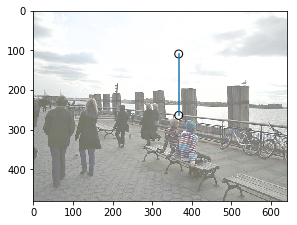

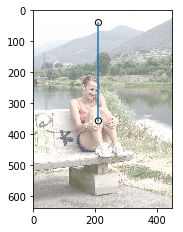

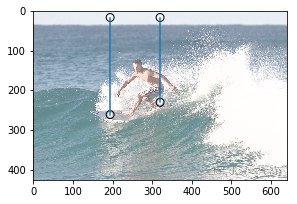

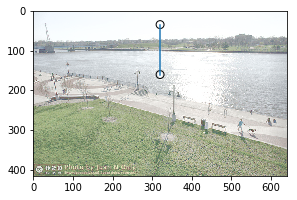

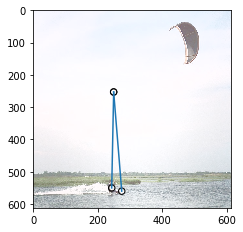

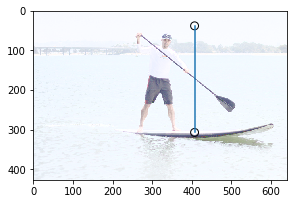

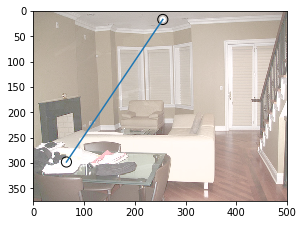

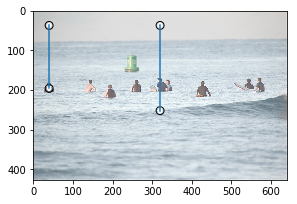

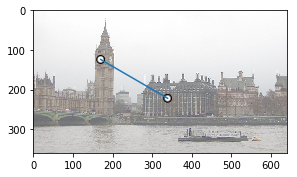

In [25]:
# Choosen images for each of the 9 graphs: 
train_graphs_map = {g['graph']['name']:g for g in train_graphs}
groups =[(0,111099),(1,13172),(2,1308),(3,109),(4,781),(5,10600),(6,21645),(7,2536),(8,116819)]


for j, el in enumerate(groups):
    g = train_graphs_map[el[1]]
    freq_graph = freq_graphs[paper_graphs[el[0]]]['g']
    res = subgraph_isomorphism(freq_graph, g)
    plot_results([(g,res[0])], freq_graph)